### Importando dependências

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# Definindo o DataFrame com os resultados das predições dos modelos
def build_dataframe(results):
    df = pd.DataFrame(results)
    df = df.sort_values(by=['model_name'], ascending=False).reset_index(drop=True)
    return df

In [3]:
# Define o yhat, a matriz de confusão e os scores necessários para o modelo
def plot_confusion_matrix(model, X, y, model_name, model_desc, plot=True):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    
    if plot:
        fig, ax = plt.subplots(figsize=(4,2))
        cm = confusion_matrix(y, y_pred, labels=model.classes_)
        display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        display.plot(ax=ax)
        plt.title(model_name)
    
    data = {
        'model_name': model_name,
        'description': model_desc,
        'accuracy': round(accuracy_score(y, y_pred), 4),
        'precision': round(precision_score(y, y_pred), 4),
        'recall': round(recall_score(y, y_pred), 4),
        'roc': round(roc_auc_score(y, y_pred_prob), 4)
    }
    
    return data

### Lendo a base de dados

In [4]:
train_df = pd.read_csv("../dataset/train.csv")
test_df = pd.read_csv("../dataset/test.csv")

In [5]:
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
415,416,0,3,"Meek, Mrs. Thomas (Annie Louise Rowley)",female,NaN,0,0,343095,8.0500,NaN,S
321,322,0,3,"Danoff, Mr. Yoto",male,27.0,0,0,349219,7.8958,NaN,S
51,52,0,3,"Nosworthy, Mr. Richard Cater",male,21.0,0,0,A/4. 39886,7.8000,NaN,S
459,460,0,3,"O'Connor, Mr. Maurice",male,NaN,0,0,371060,7.7500,NaN,Q
749,750,0,3,"Connaghton, Mr. Michael",male,31.0,0,0,335097,7.7500,NaN,Q


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Visualizando a base de dados

In [7]:
train_df.shape

(891, 12)

<strong>A maioria dos homens a bordo do titanic morreram, ao passo que as mulheres foram priorizadas.</strong>

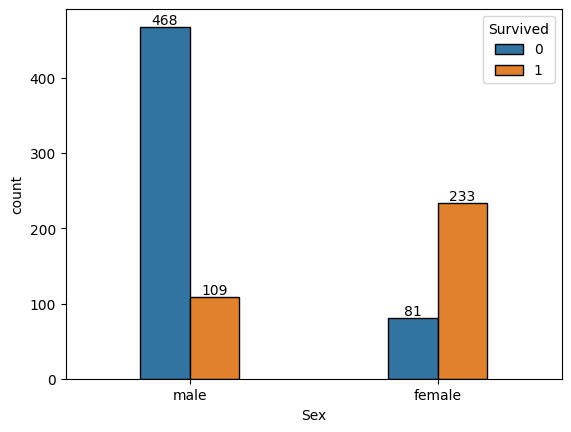

In [8]:
cp = sns.countplot(data=train_df, x='Sex', hue='Survived', edgecolor='black', width=.4)
cp.bar_label(cp.containers[0])
cp.bar_label(cp.containers[1])
plt.show()

In [9]:
dead_males = 468 / (468 + 109)
dead_females = 81 / (233 + 81)
survived_females = 233 / (233 + 109)
from_dead_males = 468 / (468 + 81)

print("De todos os homens, morreram:", round(dead_males * 100, 4), "%")
print("De todas as mulheres, morreram:", round(dead_females * 100, 4), "%")
print("Percentual de sobreviventes mulheres:", round(survived_females * 100, 4), "%")
print("Percentual de homens entre os mortos:", round(from_dead_males * 100, 4), "%")

De todos os homens, morreram: 81.1092 %
De todas as mulheres, morreram: 25.7962 %
Percentual de sobreviventes mulheres: 68.1287 %
Percentual de homens entre os mortos: 85.2459 %


<strong>Vendo cada classe de passageiros separadamente, a primeira classe é a única com mais sobreviventes que mortos. Em contrapartida, a terceira classe foi em grande parte morta.</strong>

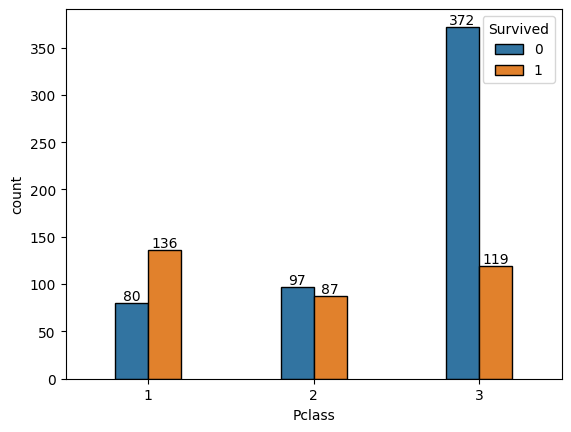

In [10]:
cp = sns.countplot(data=train_df, x='Pclass', hue='Survived', edgecolor='black', width=.4)
cp.bar_label(cp.containers[0])
cp.bar_label(cp.containers[1])
plt.show()

In [11]:
survived_p1 = 136 / (80 + 136)
survived_p3 = 119 / (372 + 119)

print("Percentual de sobreviventes na primeira classe:", round(survived_p1 * 100, 4), "%")
print("Percentual de sobreviventes na terceira classe:", round(survived_p3 * 100, 4), "%")

Percentual de sobreviventes na primeira classe: 62.963 %
Percentual de sobreviventes na terceira classe: 24.2363 %


<strong>Analisando esse scatterplot de</strong> <em>Age vs Fare</em>, <strong>à medida que a Fare aumenta, maiores são as chances de sobreviver independente da sua idade. No entanto, percebe-se que recém-nascidos e demais crianças tiveram mais chance de sobreviver mesmo com pequena Fare.</strong> 

<Axes: xlabel='Age', ylabel='Fare'>

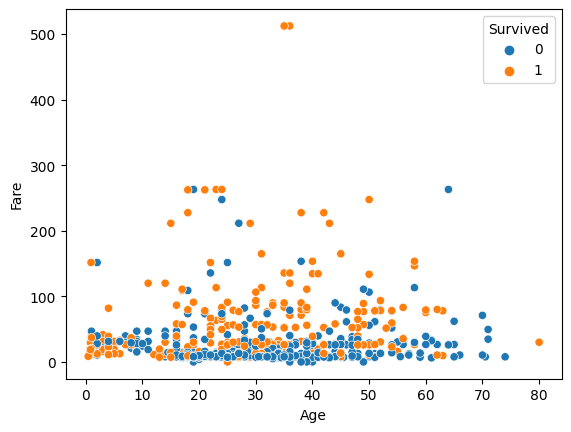

In [12]:
sns.scatterplot(data=train_df, x='Age', y='Fare', hue='Survived')

<strong>Histograma com as distribuições de idade dos sobreviventes e mortos.</strong>

<Axes: xlabel='Age', ylabel='Count'>

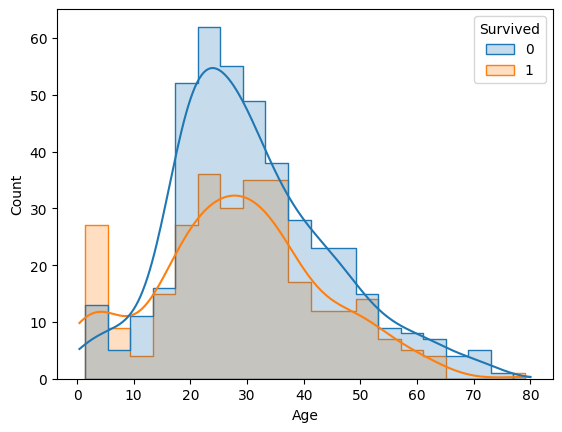

In [13]:
sns.histplot(data=train_df, x='Age', hue='Survived', multiple='layer', shrink=0.5, kde=True, bins=20, element='step')

<strong>Histograma e boxplot com as distribuições de idades de homens e mulheres a bordo.</strong>

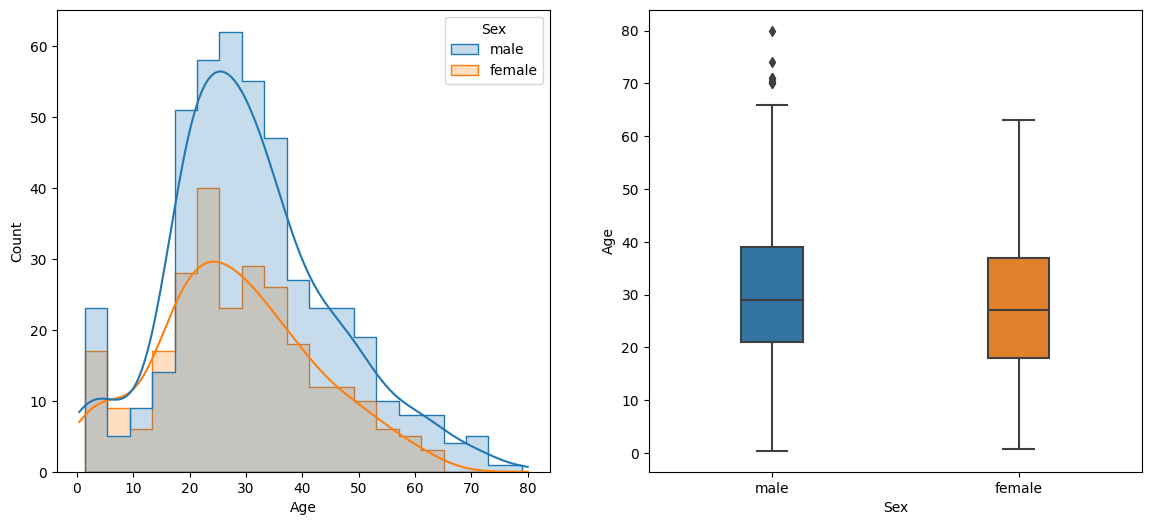

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))
sns.histplot(data=train_df, x='Age', hue='Sex', multiple='layer', shrink=0.5, kde=True, bins=20, element='step', ax=ax[0])
sns.boxplot(data=train_df, x='Sex', y='Age', width=0.25, ax=ax[1])
plt.show()

<strong>Histplot e boxplots mostrando a relação de idade, sexo e sobrevivência.</strong>

<Axes: xlabel='Survived', ylabel='Age'>

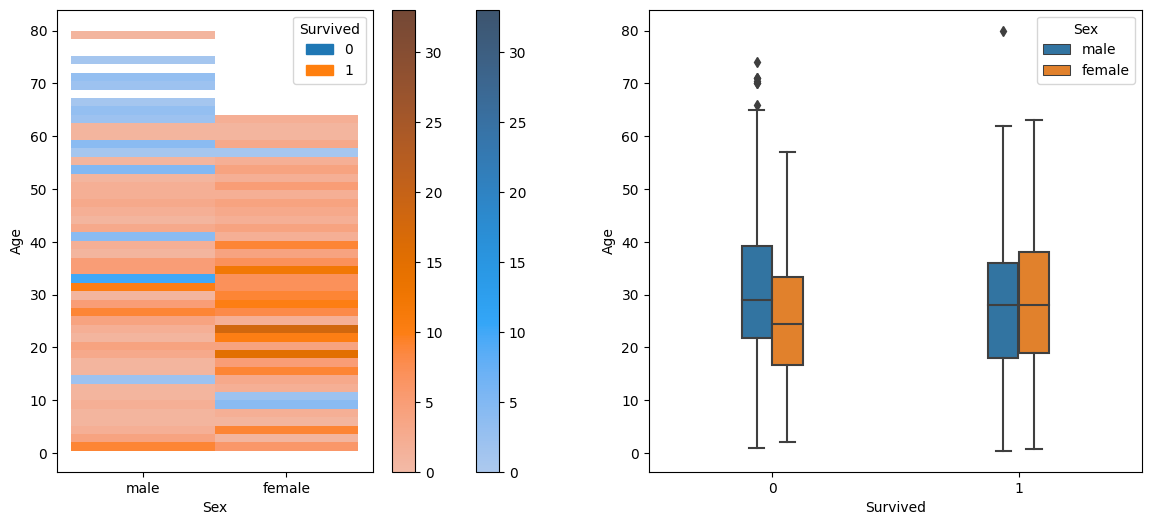

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))
sns.histplot(data=train_df, x='Sex', y='Age', hue='Survived', bins=50, cbar=True, ax=ax[0])
sns.boxplot(data=train_df, x='Survived', y='Age', hue='Sex', width=0.25, ax=ax[1])

### Pré-processamento

Identificando percentual de valores nulos em cada uma das features.

In [16]:
percent = train_df.isnull().mean()
percent

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Selecionando as colunas com percentual de valor nulo maior que 75% para serem removidas.

In [17]:
most_null_cols = percent[percent > 0.75].index
train_df = train_df.drop(columns=most_null_cols)
train_df.sample(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
651,652,1,2,"Doling, Miss. Elsie",female,18.0,0,1,231919,23.0,S


Essas três features são únicas para cada registro da base de dados. Assim, não são consideradas úteis para a predição e são removidas.

In [18]:
train_df = train_df.drop(columns=['PassengerId', 'Name','Ticket'])

In [19]:
train_df.sample(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
286,1,3,male,30.0,0,0,9.5,S


Após remover essas quatro features, separamos a base de dados na matriz de features <em>X_</em> e no target vector <em>y_</em>.

In [20]:
# Matriz de features X e vetor TARGET y
X_ = train_df.loc[:, train_df.columns != 'Survived']
y_ = train_df.Survived

Separamos, portanto, os conjuntos de treino e teste considerando a proporção de 25% de amostras para o conjunto de testes.

In [21]:
# Separando a base pré-processada em bases treino e teste
# seguindo uma proporção de 25% para a de teste
X_train, X_test, y_train, y_test = train_test_split(
X_, y_, test_size=.25, random_state=42)

### Definindo o <em>ColumnTransformer</em> para tratar os dados de treinamento e de predições

Nós utilizamos uma pipeline principal cujos <em>steps</em> são basicamente um <strong>ColumnTransformer</strong> (comum a todos os modelos) e um <em>estimator</em>.

Temos aqui 2 variáveis originalmente categóricas no dataset e as restantes são numéricas. Cada uma receberá um tratamento diferente no nosso ColumnTransformer.

In [22]:
types = X_.dtypes.reset_index()
types.columns = ['Feature', 'type']
types

,Feature,type
0,Pclass,int64
1,Sex,object
2,Age,float64
3,SibSp,int64
4,Parch,int64
5,Fare,float64
6,Embarked,object


In [23]:
CATEGORICAL_FEATURES = X_.select_dtypes(include='object').columns.tolist()
NUMERICAL_FEATURES = X_.select_dtypes(exclude='object').columns.tolist()

Essa pipeline será incorporada ao ColumnTransformer e é responsável por fazer o <strong><em>imputing</em></strong> e o <strong><em>scaling</em></strong> das features numéricas.

In [24]:
numerical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='mean')),
           ('scaler', MinMaxScaler())
    ]
)

Essa pipeline será incorporada ao ColumnTransformer e é responsável por fazer o <strong><em>imputing</em></strong> e o <strong><em>encoding</em></strong> das features categóricas.

In [25]:
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

Aqui definimos de fato o column transformer, com as duas pipelines associadas às suas variáveis numéricas ou categóricas.

In [26]:
column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ]
)

column_transformer

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked'])])

### Utilizando GridSearchCV para buscar melhor configuração de hiperparâmetros.

Ao longo dessa seção, será utilizada essa pipeline. O objeto <em>column_transformer</em> foi definido previamente e o estimator é a default decision tree. Seus hiperparâmetros serão tunados com o gridsearch.

In [27]:
pipe = Pipeline(
    steps=[('transformer', column_transformer),
           ('estimator', DecisionTreeClassifier())
    ]
)

In [28]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator', DecisionTreeClassifier())])

Acurácia para a base de testes considerando a decision tree default.

In [29]:
pipe.score(X_test, y_test)

0.7309417040358744

Dicionário com os possíveis valores dos parâmetros da decision tree que queremos tunar.

In [30]:
min_samples_leaf_range = [1, 5, 10, 15, 20, 25, 30]
min_samples_split_range = [2, 3, 4, 5, 6]

params = {'estimator__criterion': ['gini', 'entropy', 'log_loss'],
          'estimator__splitter': ['best', 'random'],
          'estimator__min_samples_leaf': min_samples_leaf_range,
          'estimator__min_samples_split': min_samples_split_range,
          'estimator__max_depth': [None, 3, 4, 5, 6],
          'estimator__max_leaf_nodes': [4, 6, 8, 10]}

#### Optando por maximizar o recall score

Instanciamos o gridsearch passando a pipeline <em>pipe</em> e o dicionário <em>params</em>. Consideramos dois scores: recall e ROC curve. O parâmetro do gridsearch "refit", de acordo com a documentação do scikit-learn, consideramos o <em>recall_score</em> para reajustar o melhor estimador a fim de maximizar esse score.

In [31]:
tree_gscv = GridSearchCV(estimator=pipe, param_grid=params, verbose=True, scoring=['recall', 'roc_auc'], refit='recall').fit(X_train, y_train)

Fitting 5 folds for each of 4200 candidates, totalling 21000 fits


In [32]:
tree_gscv

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Embarked...
                                        DecisionTreeClassifier())]),
             param_grid={'estimator__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                         'estimator__max_depth': [None, 3, 4, 5, 6],
                         'estimator__max_leaf_nodes': [4, 6, 8, 10],
                         'estimator__min_samples_leaf': [1, 5, 10, 15, 20, 25,
                                                         30],
                         'estimator__min_samples_split': [2, 3, 4, 5, 6],
                         'estimator__splitter': ['best', 'random']},
             refit='recall', scoring=['recall', 'roc_auc'], verbose=True)

In [33]:
tree_gscv.scorer_

{'recall': make_scorer(recall_score, average=binary),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}

Os melhores parâmetros encontrados seguindo a lógica previamente definida.

In [34]:
tree_gscv.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_leaf_nodes': 6,
 'estimator__min_samples_leaf': 10,
 'estimator__min_samples_split': 2,
 'estimator__splitter': 'best'}

In [35]:
best_1 = tree_gscv.best_estimator_.steps[1][1]
best_1

DecisionTreeClassifier(max_leaf_nodes=6, min_samples_leaf=10)

Árvore de decisão correspondente ao melhor estimador buscado pelo gridsearch.

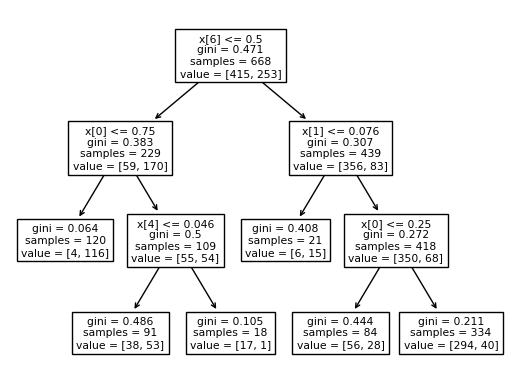

In [36]:
plot_tree(best_1)
plt.show()

Matriz de confusão para essa decision tree.

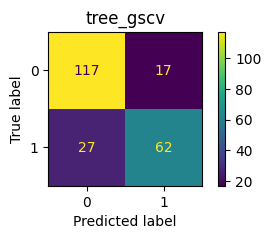

In [37]:
result_1_train = plot_confusion_matrix(tree_gscv, X_train, y_train, 'tree_gscv', 'best decision tree with recall refit tuning', False)
result_1 = plot_confusion_matrix(tree_gscv, X_test, y_test, 'tree_gscv', 'best decision tree with recall refit tuning')

In [38]:
result_1

{'model_name': 'tree_gscv',
 'description': 'best decision tree with recall refit tuning',
 'accuracy': 0.8027,
 'precision': 0.7848,
 'recall': 0.6966,
 'roc': 0.8483}

#### Optando por maximizar o roc_auc score

Instanciamos o gridsearch passando a pipeline <em>pipe</em> e o dicionário <em>params</em>. Consideramos dois scores: recall e ROC curve. O parâmetro do gridsearch "refit", de acordo com a documentação do scikit-learn, consideramos o <em>roc_auc_score</em> para reajustar o melhor estimador a fim de maximizar esse score.

In [39]:
tree_gscv_2 = GridSearchCV(estimator=pipe, param_grid=params, verbose=True, scoring=['recall', 'roc_auc'], refit='roc_auc').fit(X_train, y_train)

Fitting 5 folds for each of 4200 candidates, totalling 21000 fits


In [40]:
tree_gscv_2

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Embarked...
                                        DecisionTreeClassifier())]),
             param_grid={'estimator__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                         'estimator__max_depth': [None, 3, 4, 5, 6],
                         'estimator__max_leaf_nodes': [4, 6, 8, 10],
                         'estimator__min_samples_leaf': [1, 5, 10, 15, 20, 25,
                                                         30],
                         'estimator__min_samples_split': [2, 3, 4, 5, 6],
                         'estimator__splitter': ['best', 'random']},
             refit='roc_auc', scoring=['recall', 'roc_auc'], verbose=True)

In [41]:
tree_gscv_2.scorer_

{'recall': make_scorer(recall_score, average=binary),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}

In [42]:
best_2 = tree_gscv_2.best_estimator_.steps[1][1]
best_2

DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=10,
                       min_samples_leaf=5, min_samples_split=3,
                       splitter='random')

Os melhores parâmetros encontrados seguindo a lógica previamente definida.

In [43]:
tree_gscv_2.best_params_

{'estimator__criterion': 'log_loss',
 'estimator__max_depth': 6,
 'estimator__max_leaf_nodes': 10,
 'estimator__min_samples_leaf': 5,
 'estimator__min_samples_split': 3,
 'estimator__splitter': 'random'}

Árvore de decisão correspondente ao melhor estimador buscado pelo gridsearch.

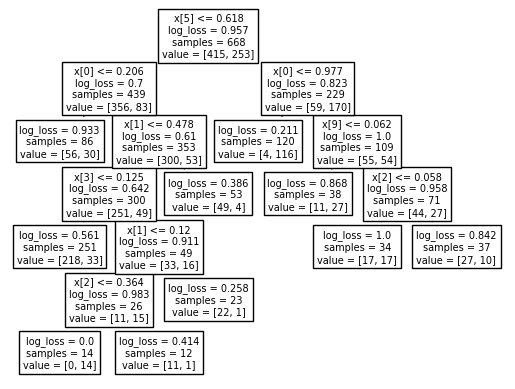

In [44]:
plot_tree(best_2)
plt.show()

Matriz de confusão para essa segunda decision tree.

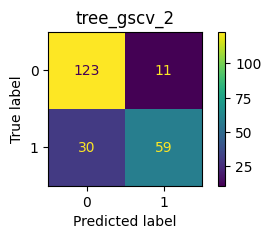

In [45]:
result_2_train = plot_confusion_matrix(tree_gscv_2, X_train, y_train, 'tree_gscv_2', 'best decision tree with roc_auc refit tuning', False)
result_2 = plot_confusion_matrix(tree_gscv_2, X_test, y_test, 'tree_gscv_2', 'best decision tree with roc_auc refit tuning')

In [46]:
result_2

{'model_name': 'tree_gscv_2',
 'description': 'best decision tree with roc_auc refit tuning',
 'accuracy': 0.8161,
 'precision': 0.8429,
 'recall': 0.6629,
 'roc': 0.8651}

### Utilizando random forests considerando as melhores decision trees encontradas com o GridSearch anteriormente.

#### Random forest maximizando o <em>recall_score</em>.

Definimos essa pipeline com o mesmo objeto <em>column_transformer</em>, porém o estimador é dado por uma random forest cujos hiperparâmetros são aqueles tunados pelo GridSearchCV considerando maximizar o <em>recall_score</em>.

In [47]:
forest = RandomForestClassifier(max_leaf_nodes=6, min_samples_leaf=10, random_state=42)

forest_pipe = Pipeline(
    steps=[('transformer', column_transformer),
           ('estimator', forest)
    ]
)

In [48]:
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator',
                 RandomForestClassifier(max_leaf_nodes=6, min_samples_leaf=10,
                                        random_state=42))])

Matriz de confusão para os resultados médios dessa random forest.

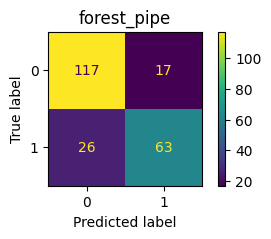

In [49]:
result_forest_1_train = plot_confusion_matrix(forest_pipe, X_train, y_train, 'forest_pipe', 'random forest with tree_gscv hyperparameters', False)
result_forest_1 = plot_confusion_matrix(forest_pipe, X_test, y_test, 'forest_pipe', 'random forest with tree_gscv hyperparameters')

Temos uma estreita melhora no <em>recall_score</em> e na curva ROC.

In [50]:
result_forest_1

{'model_name': 'forest_pipe',
 'description': 'random forest with tree_gscv hyperparameters',
 'accuracy': 0.8072,
 'precision': 0.7875,
 'recall': 0.7079,
 'roc': 0.8712}

#### Random forest maximizando o <em>roc_auc_score</em>.

Definimos essa pipeline com o mesmo objeto <em>column_transformer</em>, porém o estimador é dado por uma random forest cujos hiperparâmetros são aqueles tunados pelo GridSearchCV considerando maximizar o <em>roc_auc_score</em>.

In [51]:
forest_2 = RandomForestClassifier(max_depth=6, criterion='entropy', max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=5, random_state=42)

forest_pipe_2 = Pipeline(
    steps=[('transformer', column_transformer),
           ('estimator', forest_2)
    ]
)

In [52]:
forest_pipe_2.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator',
                 RandomForestClassifier(criterion='entropy', max_depth=6,
                                        max_leaf_nodes=10, min_samples_leaf=5,
                                        min_samples_split=5,
                                        random_state=42))])

Matriz de confusão para os resultados médios dessa random forest.

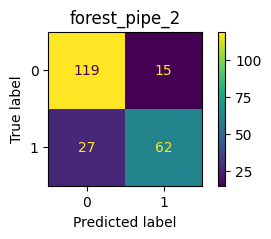

In [53]:
result_forest_2_train = plot_confusion_matrix(forest_pipe_2, X_train, y_train, 'forest_pipe_2', 'random forest with tree_gscv_2 hyperparameters', False)
result_forest_2 = plot_confusion_matrix(forest_pipe_2, X_test, y_test, 'forest_pipe_2', 'random forest with tree_gscv_2 hyperparameters')

É perceptível que há uma perda relativa no <em>precision_score</em>. No entanto, além de obtermos a melhor curva ROC dentre os outros modelos, há uma melhora também no recall. É fato que essa random forest melhor se ajusta a essa base de dados a fim de melhor equilibrar os scores.

In [54]:
result_forest_2

{'model_name': 'forest_pipe_2',
 'description': 'random forest with tree_gscv_2 hyperparameters',
 'accuracy': 0.8117,
 'precision': 0.8052,
 'recall': 0.6966,
 'roc': 0.8803}

### Considerando o melhor MLP cujo fine tuning foi obtido em relação a uma outra base.

Pipeline definida com o mesmo ColumnTransformer e esse MLP como estimador.

In [55]:
mlp = MLPClassifier(hidden_layer_sizes=(16,8), activation="tanh", random_state=42, max_iter=800)

mlp_pipe = Pipeline(
    steps=[('transformer', column_transformer),
           ('estimator', mlp)
    ]
)

In [56]:
mlp_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(16, 8),
                               max_iter=800, random_state=42))])

Matriz de confusão com os resultados para essa base de testes considerando o MLP.

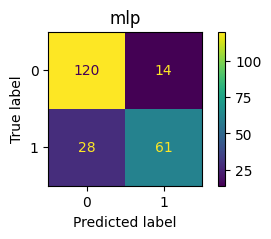

In [57]:
result_mlp_train = plot_confusion_matrix(mlp_pipe, X_train, y_train, 'mlp', 'multilayer perceptron', False)
result_mlp = plot_confusion_matrix(mlp_pipe, X_test, y_test, 'mlp', 'multilayer perceptron')

Há uma pequena melhora na curva ROC em comparação com a melhor encontrada previamente. Uma pequena melhora na precisão e pequena perda no recall. Também acaba equilibrando melhor os scores considerados. Possivelmente, como se trata de uma base de dados completamente diferente da usada para tunar esse MLP, esta configuração de hiperparâmetros não deve ser a melhor para ajustar a rede neural a prever essa base do titanic.

In [58]:
result_mlp

{'model_name': 'mlp',
 'description': 'multilayer perceptron',
 'accuracy': 0.8117,
 'precision': 0.8133,
 'recall': 0.6854,
 'roc': 0.886}

### Resultados finais no DataFrame

O MLP e a segunda random forest são os dois modelos que melhor conseguem equilibrar os scores e consequentemente a matriz de confusão para essa base de dados. Não coincidentemente, esses dois modelos são <strong><em>strong classifiers</em></strong>.

In [59]:
results_test = [result_1] + [result_2] + [result_forest_1] + [result_forest_2] + [result_mlp]
results_test = build_dataframe(results_test)
results_test

,model_name,description,accuracy,precision,recall,roc
0,tree_gscv_2,best decision tree with roc_auc refit tuning,0.8161,0.8429,0.6629,0.8651
1,tree_gscv,best decision tree with recall refit tuning,0.8027,0.7848,0.6966,0.8483
2,mlp,multilayer perceptron,0.8117,0.8133,0.6854,0.8860
3,forest_pipe_2,random forest with tree_gscv_2 hyperparameters,0.8117,0.8052,0.6966,0.8803
4,forest_pipe,random forest with tree_gscv hyperparameters,0.8072,0.7875,0.7079,0.8712


In [60]:
results_train = [result_1_train] + [result_2_train] + [result_forest_1_train] + [result_forest_2_train] + [result_mlp_train]
results_train = build_dataframe(results_train)
results_train

,model_name,description,accuracy,precision,recall,roc
0,tree_gscv_2,best decision tree with roc_auc refit tuning,0.8338,0.9128,0.6206,0.8732
1,tree_gscv,best decision tree with recall refit tuning,0.8249,0.7931,0.7273,0.8624
2,mlp,multilayer perceptron,0.8174,0.8503,0.6285,0.8603
3,forest_pipe_2,random forest with tree_gscv_2 hyperparameters,0.8413,0.8483,0.7075,0.8842
4,forest_pipe,random forest with tree_gscv hyperparameters,0.8069,0.7870,0.6719,0.8649
